Создание фазовых портретов для системы конкуренции
Система уравнений:
$du₁/dt = u₁(1 - u₁ - ε₁u₂)$
$du₂/dt = γu₂(1 - u₂ - ε₂u₁)$


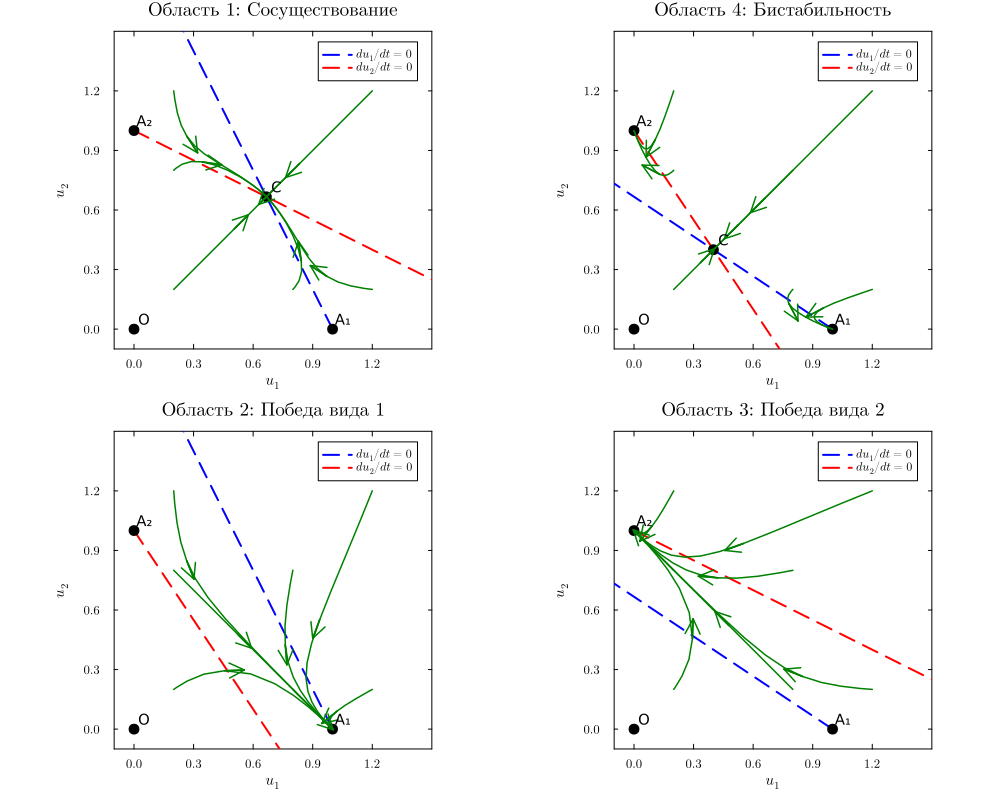

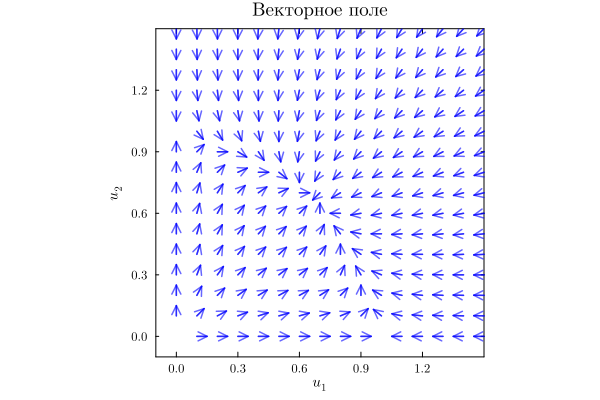


Графики сохранены:
- competition_phase_portraits.png
- competition_vector_field.png

Анализ стационарных точек:

Победа вида 1 (ε₁=0.5, ε₂=1.5):
  O: u₁ = 0.0, u₂ = 0.0
  A₁: u₁ = 1.0, u₂ = 0.0
  A₂: u₁ = 0.0, u₂ = 1.0

Бистабильность (ε₁=1.5, ε₂=1.5):
  O: u₁ = 0.0, u₂ = 0.0
  A₁: u₁ = 1.0, u₂ = 0.0
  A₂: u₁ = 0.0, u₂ = 1.0
  C: u₁ = 0.4, u₂ = 0.4

Победа вида 2 (ε₁=1.5, ε₂=0.5):
  O: u₁ = 0.0, u₂ = 0.0
  A₁: u₁ = 1.0, u₂ = 0.0
  A₂: u₁ = 0.0, u₂ = 1.0

Сосуществование (ε₁=0.5, ε₂=0.5):
  O: u₁ = 0.0, u₂ = 0.0
  A₁: u₁ = 1.0, u₂ = 0.0
  A₂: u₁ = 0.0, u₂ = 1.0
  C: u₁ = 0.667, u₂ = 0.667


In [1]:
using DifferentialEquations
using Plots
using LaTeXStrings

default(fontfamily="Computer Modern",
        titlefontsize=12,
        guidefontsize=10,
        tickfontsize=8,
        legendfontsize=8,
        linewidth=1.5,
        grid=false,
        framestyle=:box)

# Система уравнений (4.1.3)
function competition_system!(du, u, p, t)
    u1, u2 = u
    γ, ε1, ε2 = p

    du[1] = u1 * (1 - u1 - ε1 * u2)
    du[2] = γ * u2 * (1 - u2 - ε2 * u1)
end

# Функция для вычисления нулевых изоклин
function compute_isoclines(γ, ε1, ε2)
    # Изоклина для u1: 1 - u1 - ε1*u2 = 0 => u1 = 1 - ε1*u2
    u2_range = 0:0.01:2
    u1_isocline1 = 1 .- ε1 .* u2_range

    # Изоклина для u2: 1 - u2 - ε2*u1 = 0 => u2 = 1 - ε2*u1
    u1_range = 0:0.01:2
    u2_isocline2 = 1 .- ε2 .* u1_range

    return u2_range, u1_isocline1, u1_range, u2_isocline2
end

# Функция для вычисления стационарных точек
function compute_equilibrium_points(ε1, ε2)
    points = []

    # Тривиальные точки
    push!(points, ([0.0, 0.0], "O"))
    push!(points, ([1.0, 0.0], "A₁"))
    push!(points, ([0.0, 1.0], "A₂"))

    # Нетривиальная точка
    det = 1 - ε1 * ε2
    if det ≠ 0
        u1_star = (1 - ε1) / det
        u2_star = (1 - ε2) / det
        if u1_star > 0 && u2_star > 0
            push!(points, ([u1_star, u2_star], "C"))
        end
    end

    return points
end

# Функция для вычисления производной в точке
function compute_derivative(u, p)
    du = [0.0, 0.0]
    competition_system!(du, u, p, 0.0)
    return du
end

# Функция для создания фазового портрета с траекториями
function create_phase_portrait(γ, ε1, ε2; title="")
    # Создаем основу графика
    p = plot(xlims=(-0.1, 1.5), ylims=(-0.1, 1.5), aspect_ratio=:equal,
             xlabel=L"u_1", ylabel=L"u_2", title=title)

    # Вычисляем изоклины
    u2_range, u1_isocline1, u1_range, u2_isocline2 = compute_isoclines(γ, ε1, ε2)

    # Рисуем изоклины
    plot!(p, u1_isocline1, u2_range, linestyle=:dash, linewidth=2,
          color=:blue, label=L"du_1/dt = 0")
    plot!(p, u1_range, u2_isocline2, linestyle=:dash, linewidth=2,
          color=:red, label=L"du_2/dt = 0")

    # Вычисляем стационарные точки
    equilibrium_points = compute_equilibrium_points(ε1, ε2)

    # Рисуем стационарные точки
    for (point, label) in equilibrium_points
        scatter!(p, [point[1]], [point[2]], markersize=6, color=:black, label="")
        annotate!(p, point[1] + 0.05, point[2] + 0.05, text(label, 10, :black))
    end

    # Параметры для моделирования траекторий
    tspan = (0.0, 20.0)
    p_params = [γ, ε1, ε2]

    # Начальные условия для траекторий
    initial_conditions = [
        [0.2, 0.2], [0.8, 0.2], [0.2, 0.8], [0.8, 0.8],
        [1.2, 0.2], [0.2, 1.2], [1.2, 1.2]
    ]

    # Интегрируем и рисуем траектории
    for u0 in initial_conditions
        prob = ODEProblem(competition_system!, u0, tspan, p_params)
        sol = solve(prob, Tsit5())

        plot!(p, sol[1,:], sol[2,:], linewidth=1.5, color=:green, label="")

        # Добавляем стрелки направления
        if length(sol.t) > 10
            idx = min(5, length(sol.t) ÷ 3)
            t_point = sol.t[idx]
            u_point = [sol[1, idx], sol[2, idx]]  # Явно создаем массив
            du = compute_derivative(u_point, p_params)

            # Нормализуем для визуализации
            norm_du = sqrt(du[1]^2 + du[2]^2)
            if norm_du > 0
                scale = 0.1 / norm_du
                quiver!(p, [u_point[1]], [u_point[2]],
                        quiver=([du[1]*scale], [du[2]*scale]),
                        color=:green)
            end
        end
    end

    return p
end

# Функция для создания векторного поля
function create_vector_field(γ, ε1, ε2)
    u1_range = 0:0.1:1.5
    u2_range = 0:0.1:1.5

    p = plot(xlims=(-0.1, 1.5), ylims=(-0.1, 1.5), aspect_ratio=:equal,
             xlabel=L"u_1", ylabel=L"u_2", title="Векторное поле")

    # Создаем сетку для векторного поля
    for u1 in u1_range, u2 in u2_range
        du = compute_derivative([u1, u2], [γ, ε1, ε2])

        norm_du = sqrt(du[1]^2 + du[2]^2)
        if norm_du > 0
            scale = 0.05 / norm_du
            quiver!(p, [u1], [u2],
                    quiver=([du[1]*scale], [du[2]*scale]),
                    color=:blue, alpha=0.6)
        end
    end

    return p
end

# Основная функция для создания всех графиков
function create_competition_analysis()
    # Параметры для разных режимов (соответствуют областям с рисунка 4.1.1)
    parameters = Dict(
        "Область 1: Сосуществование" => (1.0, 0.5, 0.5),
        "Область 2: Победа вида 1" => (1.0, 0.5, 1.5),
        "Область 3: Победа вида 2" => (1.0, 1.5, 0.5),
        "Область 4: Бистабильность" => (1.0, 1.5, 1.5)
    )

    plots_list = []

    for (title, params) in parameters
        γ, ε1, ε2 = params  # Распаковываем параметры
        p = create_phase_portrait(γ, ε1, ε2, title=title)
        push!(plots_list, p)
    end

    # Создаем общий график
    combined_plot = plot(plots_list..., layout=(2,2), size=(1000, 800))

    # Дополнительно: векторное поле для первого случая
    vector_field = create_vector_field(1.0, 0.5, 0.5)

    return combined_plot, vector_field
end

# Запускаем анализ
println("Создание фазовых портретов для системы конкуренции")
println("Система уравнений:")
println(L"du₁/dt = u₁(1 - u₁ - ε₁u₂)")
println(L"du₂/dt = γu₂(1 - u₂ - ε₂u₁)")

main_plot, vec_field = create_competition_analysis()

display(main_plot)
savefig(main_plot, "competition_phase_portraits.png")

display(vec_field)
savefig(vec_field, "competition_vector_field.png")

println("\nГрафики сохранены:")
println("- competition_phase_portraits.png")
println("- competition_vector_field.png")

# Анализ стационарных точек для каждого случая
println("\nАнализ стационарных точек:")
parameters = Dict(
    "Сосуществование (ε₁=0.5, ε₂=0.5)" => (0.5, 0.5),
    "Победа вида 1 (ε₁=0.5, ε₂=1.5)" => (0.5, 1.5),
    "Победа вида 2 (ε₁=1.5, ε₂=0.5)" => (1.5, 0.5),
    "Бистабильность (ε₁=1.5, ε₂=1.5)" => (1.5, 1.5)
)

for (desc, (ε1, ε2)) in parameters
    points = compute_equilibrium_points(ε1, ε2)
    println("\n$desc:")
    for (point, label) in points
        println("  $label: u₁ = $(round(point[1], digits=3)), u₂ = $(round(point[2], digits=3))")
    end
end